<a href="https://colab.research.google.com/github/harold286/Harold_Hoyos/blob/main/Semana2/LimpiezaPandas/Taller_Forecasting_Ocupacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [157]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

In [158]:
# Cargar dataset de ocupacion de sitios de parqueo

df= pd.read_csv('SJ.csv')
df.head()

,date,idCompany,numTrx
0,2022-08,1,68599
1,2022-09,1,86862
2,2022-10,1,99611
3,2022-11,1,109018
4,2022-12,1,115665


In [159]:
#revisar cola y cabecera del dataseat

df['date'] = pd.to_datetime(df['date'], format='%Y-%m')

# Mostrar la cabecera del dataset (primeras 5 filas por defecto)
print("Cabecera del dataset:")
print(df.head())
print("\n")

# Mostrar la cola del dataset (últimas 5 filas por defecto)
print("Cola del dataset:")
print(df.tail())
print("\n")

# Mostrar información básica del dataset
print("Información del dataset:")
print(df.info())
print("\n")

Cabecera del dataset:
        date  idCompany  numTrx
0 2022-08-01          1   68599
1 2022-09-01          1   86862
2 2022-10-01          1   99611
3 2022-11-01          1  109018
4 2022-12-01          1  115665


Cola del dataset:
         date  idCompany  numTrx
13 2023-09-01          1  126851
14 2023-10-01          1  137539
15 2023-11-01          1  145327
16 2023-12-01          1  135537
17 2024-01-01          1  148111


Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       18 non-null     datetime64[ns]
 1   idCompany  18 non-null     int64         
 2   numTrx     18 non-null     int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 560.0 bytes
None




In [160]:
# Formatear la columna de fecha como año y mes
df['año_mes'] = df['date'].dt.strftime('%Y-%m')
df.head()


,date,idCompany,numTrx,año_mes
0,2022-08-01,1,68599,2022-08
1,2022-09-01,1,86862,2022-09
2,2022-10-01,1,99611,2022-10
3,2022-11-01,1,109018,2022-11
4,2022-12-01,1,115665,2022-12


In [161]:
# Verificar el nombre de los meses del dataset para comprobar que el formateo es correcto
meses = df['date'].dt.month_name().unique()
print("Nombres de los meses en el dataset:")
print(meses)
print("\n")

Nombres de los meses en el dataset:
['August' 'September' 'October' 'November' 'December' 'January' 'February'
 'March' 'April' 'May' 'June' 'July']




In [162]:
# Contar el numero de datos del dataset
num_datos = len(df)
print(f"Número total de datos en el dataset: {num_datos}")
print("\n")

Número total de datos en el dataset: 18




In [163]:
# Obtener una estadistica descriptiva básica del dataset, verificar si hay algo anormal
print("Estadística descriptiva básica:")
print(df.describe())
print("\n")

Estadística descriptiva básica:
                      date  idCompany         numTrx
count                   18       18.0      18.000000
mean   2023-04-16 18:40:00        1.0  120111.833333
min    2022-08-01 00:00:00        1.0   68599.000000
25%    2022-12-08 18:00:00        1.0  110679.750000
50%    2023-04-16 00:00:00        1.0  125518.500000
75%    2023-08-24 06:00:00        1.0  135321.000000
max    2024-01-01 00:00:00        1.0  148111.000000
std                    NaN        0.0   20840.047288




In [164]:
# Revisar si el ldataset tiene datos nullos
print("Verificación de valores nulos:")
print(df.isnull().sum())
print("\n")

Verificación de valores nulos:
date         0
idCompany    0
numTrx       0
año_mes      0
dtype: int64




In [165]:
# Establecer el campo fecha como index del dataframe

df.set_index('date', inplace=True)
print(df.head())


            idCompany  numTrx  año_mes
date                                  
2022-08-01          1   68599  2022-08
2022-09-01          1   86862  2022-09
2022-10-01          1   99611  2022-10
2022-11-01          1  109018  2022-11
2022-12-01          1  115665  2022-12


In [166]:
# Verificar nuevamente el head de la tabla y comprobar que el index ahora sea la fecha

print("Head del DataFrame con fecha como índice:")
print(df.head())
print("\n")

Head del DataFrame con fecha como índice:
            idCompany  numTrx  año_mes
date                                  
2022-08-01          1   68599  2022-08
2022-09-01          1   86862  2022-09
2022-10-01          1   99611  2022-10
2022-11-01          1  109018  2022-11
2022-12-01          1  115665  2022-12




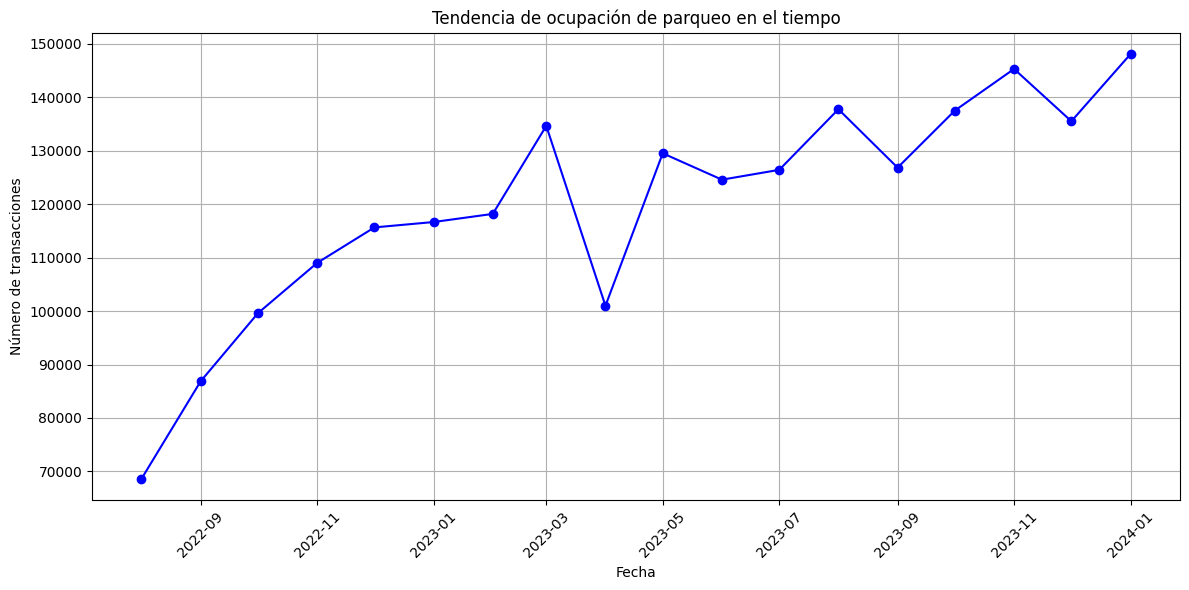

In [167]:
# Realizar una grafica de tendencia del numero de espacios ocupados en el tiempo
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['numTrx'], marker='o', linestyle='-', color='b')
plt.title('Tendencia de ocupación de parqueo en el tiempo')
plt.xlabel('Fecha')
plt.ylabel('Número de transacciones')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


In [168]:
# Eliminar las columnas que no necesiten para realizar un sistema de prediccion de ocupacion de parqueo
df_pred = df.drop('idCompany', axis=1)

In [169]:
# Escalar entre -1 y 1 los datos de la variable a predecir
scaler = MinMaxScaler(feature_range=(-1, 1))
df_pred['numTrx_scaled'] = scaler.fit_transform(df_pred[['numTrx']])


In [170]:
# Definir una ventana temporal adecuada para la prediccion y establecer las listas

window_size = 6

# Establecer las listas xtrain y ytrain para el entrenamiento
X = []
y = []

for i in range(window_size, len(df_pred)):
    X.append(df_pred['numTrx_scaled'].values[i-window_size:i])
    y.append(df_pred['numTrx_scaled'].values[i])

In [171]:
# Convertir las listas en arrays de numpy
X_train = np.array(X)
y_train = np.array(y)

In [172]:
# Verificar el shape de los datos de entrenamiento (variable independiente y dependiente)
print("Shape de X_train:", X_train.shape)
print("Shape de y_train:", y_train.shape)

Shape de X_train: (12, 6)
Shape de y_train: (12,)


In [173]:
# Construir un modelo LSTM para realizar la predicción que tenga la siguiente arquitectura
# Una capa LSTM de 256 neuronas con activación relu
# Una capa LSTM de 256 neuronas con activación relu
# Una capa LSTM de 128 neuronas con activación relu
# Una capa LSTM de 64 neuronas con activación relu
# Una capa LSTM de 32 neuronas con activación relu
# Una capa LSTM de 16 neuronas con activación relu (esta seria la ultima capa LSTM)
# Agregar operaciones de Dropout de 7% despues de cada capa LSTM
# Agregar en la etapa final una red densa con dos capas con 64 neuronas y 32 neuronas
# Finalmente agregar una capa densa de salida
# Imprimir el summary del  modelo

model = Sequential()

model.add(LSTM(256, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.07))

model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(Dropout(0.07))

model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(Dropout(0.07))

model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(Dropout(0.07))

model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(Dropout(0.07))

model.add(LSTM(16, activation='relu'))
model.add(Dropout(0.07))

model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                       │ (None, 6, 256)              │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 6, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_25 (LSTM)                       │ (None, 6, 256)              │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 6, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_26 (LSTM)                       │ (None, 6, 128)              │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_27 (LSTM)                       │ (None, 6, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_28 (LSTM)                       │ (None, 6, 32)               │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 6, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_29 (LSTM)                       │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,054,785 (4.02 MB)

 Trainable params: 1,054,785 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

In [174]:
# Compilar el modelo con una funcion de error mse y un optimizador adam
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


In [175]:
# Entrenar el modelo durante 100 epocas
# Usar el 10% de los datos de entrenamiento para validacion
# Usar un batch size de 16

history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, verbose=1)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 0.3360 - val_loss: 0.7257
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 0.3312 - val_loss: 0.7142
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.3244 - val_loss: 0.7023
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.3174 - val_loss: 0.6900
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.3105 - val_loss: 0.6773
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.3032 - val_loss: 0.6643
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 0.2957 - val_loss: 0.6510
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.2879 - val_loss: 0.6375
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 0.2804 - val_loss: 0.6234
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - loss: 0.2727 - val_loss: 0.6089
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step - loss: 0.2649 - val_loss: 0.5939
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.25

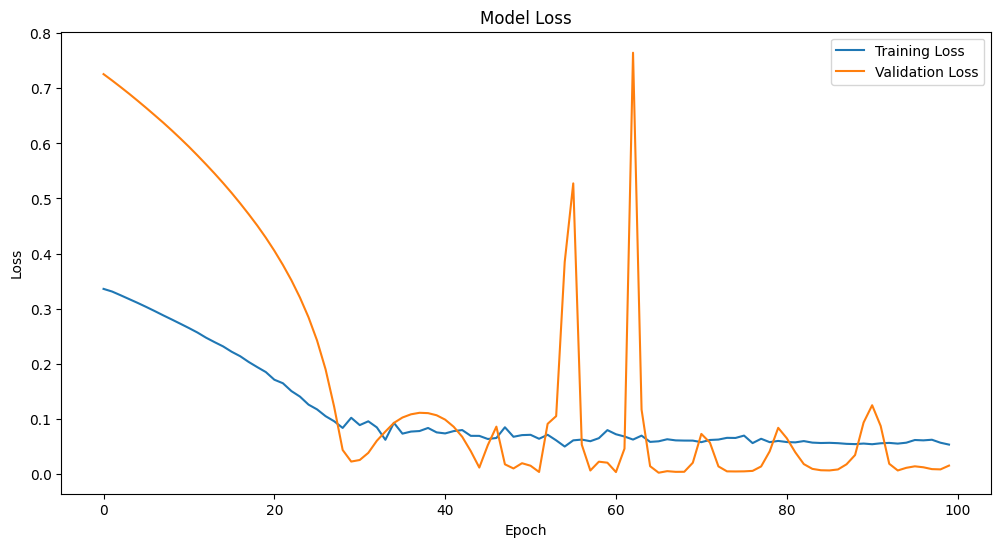

In [176]:
# Grafifcar el loss y loss de validacion para verificar que no haya overfitting
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [177]:
# Guardar el modelo y salvarlo en disco
model.save('lstm_parking_model.h5')


In [187]:
# Tome N registros historicos de su dataset y realice la predicción de ocupación para un mes particular
window_size = 2

historical_data = df['numTrx_scaled'].values[-(window_size + 1):-1]

historical_data = historical_data.reshape((1, window_size, 1))

prediccion = model.predict(historical_data)

print("Predicción escalada:", prediccion)

prediccion_desescalada = scaler.inverse_transform(prediccion)
print("Predicción desescalada (número de transacciones):", prediccion_desescalada)

KeyError: 'numTrx_scaled'

In [ ]:
# Proponga una arquitectura que permita recibir como parametros de entrada no solo los historicos de la
# serie temporal sino tambien información adicional relevante como por ejemplo el mes para el cual se
# realiza la predicción, o el número de dias festivos del mes de predicción

d